# Sentinel 2 cloud access

This notebook ({nb-download}`download <Cloud_Sentinel2_access.ipynb>`) illustrates the use of STAC and pystac-client to access and open Sentinel 2 (cloud-optimized geotiff) datasets.

```{admonition} Learning Objectives
**Goals**
- Identify and locate Sentinel 2 data
- Acquire data from the cloud
- Open data in `xarray`
```

```{admonition} Key Takeaway
By the end of this tutorial, you will be able to open Sentinel 2 Cloud Optimized Geotiffs.
```

## Notes
1. You **MUST** be working within an AWS instance. Otherwise, you will get a permissions error.
2. Authentication is still more steps than we'd like. We're working to address this - let us know if you'd like to join the conversation!

For this tutorial, feel free to run the code along with us as we live code by downsizing the zoom window and splitting your screen (or using two screens). Or you can simply watch the zoom walkthrough. Don't worry if you fall behind on the code. The notebook is standalone and you can easily run the code at your own pace another time to catch anything you missed. 

## Computing environment

We'll be using the following open source Python libraries in this notebook:

In [1]:
# Suppress library deprecation warnings
import logging
logging.captureWarnings(True)

In [2]:
import datetime
# import re

In [13]:
%matplotlib widget
import pystac_client
import geoviews as gv
import geopandas as gpd
import hvplot.pandas
# from IPython.display import display, Image
import intake # if you've installed intake-STAC, it will automatically import alongside intake
import intake_stac
import xarray as xr
import matplotlib.pyplot as plt
import boto3
import rasterio as rio
from rasterio.session import AWSSession
from rasterio.plot import show
import rioxarray as rxr
from dask.utils import SerializableLock
import os
# import fiona
import hvplot.xarray
import numpy as np
from pyproj import Proj, transform

# Search and open (Sentinel 2) raster imagery from the cloud

We will be working with Cloud Optimized GeoTIFF (COG). A COG is a GeoTIFF file with an internal organization that enables more efficient workflows and prevents having to open the entire image (see more at https://www.cogeo.org/).

Here is the [User Manual](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/product-types/level-2a) for more information about accessing Sentinel 2 S3.

## Search for Sentinel 2 imagery

To explore and access COG's easily we will use a [SpatioTemporal Asset Catalog (STAC)](https://github.com/radiantearth/stac-spec). The STAC provides a common metadata format to make it easier to index and querry S3 buckets for geospatial data.

In [4]:
# Sets up AWS credentials for acquiring images through dask/xarray
os.environ["AWS_REQUEST_PAYER"] = "requester"

# Sets up proper AWS credentials for acquiring data through rasterio
aws_session = AWSSession(boto3.Session(), requester_pays=True)

Extract geometry bounds are extracted from the ICESat-2 KML file used above so that we can perform the Sentinel 2 spatial search.

In [5]:
# Create geometry bounding box (west, south, east, north) 
bbox = (-51.3229009069365, 68.84029223511094, -48.20366423696812, 69.61656633135274)

We will search for imagery in STAC catalog using the [pystac_client](https://pystac-client.readthedocs.io/en/stable/usage.html) search tool.

In [6]:
# Search STAC API for Sentinel 2 images based on a bounding box, date and other metadata if desired

timeRange = '2019-04-20/2019-04-22' # For Landat '2019-05-06/2019-05-07' 
url = 'https://earth-search.aws.element84.com/v0'
collection = 'sentinel-s2-l2a-cogs' # Sentinel 2 Level 2A
    
api = pystac_client.Client.open(url)

items = api.search(
            bbox = bbox,
            datetime = timeRange,
            limit = 400,
            collections=collection
        ).item_collection()
    
print(f'{len(items)} items')

# Write a json file that records our search output
gjson_outfile = f'/home/jovyan/Sentinel.geojson'
items.save_object(gjson_outfile)

19 items


We can include property searches, such as path, row, cloud-cover, as well with the `properties` flag in the api.search.

We are given a pystac collection of items (images)

In [7]:
items

id: S2B_22WEC_20190422_0_L2A
"bbox: [-51.00050517087285, 69.29903000275098, -48.08358054933817, 70.30600852564982]"
created: 2020-08-28T11:41:25.124Z
sentinel:product_id: S2B_MSIL2A_20190422T151809_N0211_R068_T22WEC_20190422T204137
sentinel:sequence: 0
view:off_nadir: 0
sentinel:valid_cloud_cover: True
platform: sentinel-2b
sentinel:utm_zone: 22
proj:epsg: 32622
sentinel:grid_square: EC


Load the geojson file into geopandas and inspect the items we want to collect

In [10]:
# Load the geojson file
gf = gpd.read_file(gjson_outfile)
gf.head(2)

,id,created,sentinel:product_id,sentinel:sequence,view:off_nadir,sentinel:valid_cloud_cover,platform,sentinel:utm_zone,proj:epsg,sentinel:grid_square,datetime,instruments,constellation,eo:cloud_cover,gsd,sentinel:latitude_band,data_coverage,sentinel:data_coverage,updated,geometry
0,S2B_22WEC_20190422_0_L2A,2020-08-28 11:41:25.124000+00:00,S2B_MSIL2A_20190422T151809_N0211_R068_T22WEC_2...,0,0,True,sentinel-2b,22,32622,EC,2019-04-22 15:37:15+00:00,[msi],sentinel-2,98.33,10,W,NaN,100.0,2020-08-28 11:41:25.124000+00:00,"POLYGON ((-48.21647 69.29903, -51.00048 69.321..."
1,S2B_22WDB_20190422_0_L2A,2020-08-28 09:14:51.855000+00:00,S2B_MSIL2A_20190422T151809_N0211_R068_T22WDB_2...,0,0,True,sentinel-2b,22,32622,DB,2019-04-22 15:34:07+00:00,[msi],sentinel-2,79.60,10,W,NaN,100.0,2020-08-28 09:14:51.855000+00:00,"POLYGON ((-53.43641 68.40718, -53.54726 69.390..."


In [14]:
# Plot search area of interest and frames on a map using Holoviz Libraries (more on these later)
cols = gf.loc[:,('id','sentinel:latitude_band','sentinel:grid_square','geometry')]
cols = cols.iloc[14:17]
footprints = cols.hvplot(geo=True, line_color='k', hover_cols=['sentinel:latitude_band','sentinel:grid_square'], alpha=0.3, title='Sentinel 2 L2A',tiles='ESRI')
tiles = gv.tile_sources.CartoEco.options(width=700, height=500) 
labels = gv.tile_sources.StamenLabels.options(level='annotation')
tiles * footprints * labels

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Tiles.I    :Tiles   [x,y]
   .Polygons.I :Polygons   [Longitude,Latitude]   (sentinel:latitude_band,sentinel:grid_square)
   .WMTS.II    :WMTS   [Longitude,Latitude]

### Intake all scenes using the intake-STAC library
`Intake-STAC` facilitates discovering, exploring, and loading spatio-temporal datasets by providing Intake Drivers for STAC catalogs. This provides a simple toolkit for working with STAC catalogs and for loading STAC assets as `xarray` objects.

In [15]:
catalog = intake_stac.catalog.StacItemCollection(items)
list(catalog)

['S2B_22WEC_20190422_0_L2A',
 'S2B_22WDB_20190422_0_L2A',
 'S2B_22WFB_20190422_0_L2A',
 'S2B_22WEB_20190422_0_L2A',
 'S2B_22WFC_20190422_0_L2A',
 'S2B_22WDC_20190422_0_L2A',
 'S2A_22WEC_20190421_0_L2A',
 'S2A_22WFC_20190421_0_L2A',
 'S2A_22WFB_20190421_0_L2A',
 'S2A_22WEB_20190421_0_L2A',
 'S2A_22WFB_20190420_0_L2A',
 'S2A_22WDB_20190420_1_L2A',
 'S2A_22WDC_20190420_0_L2A',
 'S2A_22WDC_20190420_1_L2A',
 'S2A_22WEC_20190420_0_L2A',
 'S2A_22WDB_20190420_0_L2A',
 'S2A_22WEB_20190420_0_L2A',
 'S2A_22WFC_20190420_0_L2A',
 'S2A_22WEB_20190420_1_L2A']

Let's explore the metadata and keys for the first scene

In [16]:
sceneids = list(catalog)
item3 = catalog[sceneids[16]]
# item3.metadata
for keys in item3.keys():
    print (keys)

overview
thumbnail
metadata
B11
B01
B12
B02
B03
B04
AOT
B05
B06
B07
B08
B8A
B09
WVP
visual
SCL
info


We can explore the metadata for any of these:

In [17]:
item3['B02'].metadata

{'href': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/22/W/EB/2019/4/S2A_22WEB_20190420_0_L2A/B02.tif',
 'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
 'title': 'Band 2 (blue)',
 'proj:shape': [10980, 10980],
 'proj:transform': [10, 0, 499980, 0, -10, 7700040, 0, 0, 1],
 'eo:bands': [{'full_width_half_max': 0.098,
   'center_wavelength': 0.4966,
   'name': 'B02',
   'common_name': 'blue'}],
 'gsd': 10,
 'roles': ['data'],
 'plots': {'geotiff': {'kind': 'image',
   'x': 'x',
   'y': 'y',
   'frame_width': 500,
   'data_aspect': 1,
   'rasterize': True,
   'dynamic': True,
   'cmap': 'viridis'}},
 'catalog_dir': ''}

In [18]:
items[3]

id: S2B_22WEB_20190422_0_L2A
"bbox: [-51.000484089372996, 68.4035639911327, -48.205089717893756, 69.40963154119304]"
created: 2020-08-28T09:38:04.188Z
sentinel:product_id: S2B_MSIL2A_20190422T151809_N0211_R068_T22WEB_20190422T204137
sentinel:sequence: 0
view:off_nadir: 0
sentinel:valid_cloud_cover: True
platform: sentinel-2b
sentinel:utm_zone: 22
proj:epsg: 32622
sentinel:grid_square: EB


In [19]:
items[3].assets['B02'].href

'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/22/W/EB/2019/4/S2B_22WEB_20190422_0_L2A/B02.tif'

In [20]:
# Either of these codes provide the url needed to grab data from the S3 bucket using the intake-STAC catalog
print(item3.B02.metadata['href']) # must use item asset name (blue)
print (items[3].assets['B02'].href)

https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/22/W/EB/2019/4/S2A_22WEB_20190420_0_L2A/B02.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/22/W/EB/2019/4/S2B_22WEB_20190422_0_L2A/B02.tif


### Open and visualize each image using RasterIO 

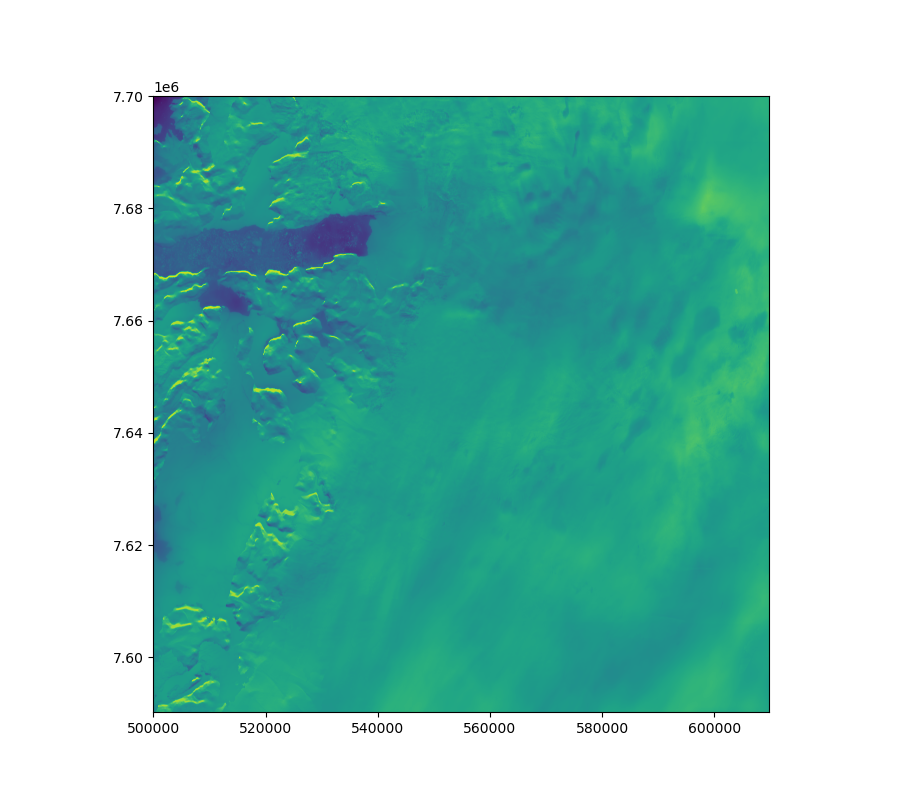

In [21]:
import rasterio as rio

# Retrieve first scene using rio
item_url = items[3].assets['B02'].href

# Read and plot with grid coordinates 
with rio.Env(aws_session):
    with rio.open(item_url) as src:
        fig, ax = plt.subplots(figsize=(9,8))
        
        # To plot
        show(src,1)
        
        # To open data into a numpy array
        profile = src.profile
        arr = src.read(1)

We can open directly into `xarray` using `rasterIO`...

### Manipulating data in Xarray

`Pandas` and `xarray` have very similar structures and ways of manipulating data, but `pandas` excels with 2-D data and `xarray` is ideal for higher dimension data. `Xarray` introduces labels in the form of dimensions, coordinates and attributes on top of Pandas-like DataFrames.

We will only scratch the surface here on what `xarray` can do. To learn more, there are great `xarray` tutorials here: https://xarray-contrib.github.io/xarray-tutorial/online-tutorial-series/01_xarray_fundamentals.html

#### RasterIO and RioXarray

We can use `rasterIO` to easily open into an `xarray` `DataSet`:

In [22]:
rastxr = xr.open_dataset(item_url,engine='rasterio')
rastxr

<xarray.Dataset>
Dimensions:      (band: 1, x: 10980, y: 10980)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05 6.098e+05
  * y            (y) float64 7.7e+06 7.7e+06 7.7e+06 ... 7.59e+06 7.59e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...

We can also open using `rioxarray`, which integrates `rasterIO` and `xarray` and is the most efficient way of opening using `rasterIO`:

In [23]:
import rioxarray as rxr

rastrxr = rxr.open_rasterio(item_url)
rastrxr

<xarray.DataArray (band: 1, y: 10980, x: 10980)>
[120560400 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05 6.098e+05
  * y            (y) float64 7.7e+06 7.7e+06 7.7e+06 ... 7.59e+06 7.59e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

We can see `Attributes` have been added to the `xarray` using the same url.

Beyond what `xarray` and `rasterIO` provide, `rioxarray` has these added benefits (plus others):
* Supports multidimensional datasets such as netCDF
* Loads in the CRS, transform, and nodata metadata in standard CF & GDAL locations
* Supports masking and scaling data
* Loads raster metadata into the attributes

For more info: https://corteva.github.io/rioxarray/stable/index.html

#### Dask

Another convenient means for opening a lot of raster data into `xarray` is using `dask`. `Xarray` integrates with Dask to support parallel computations and streaming computation on datasets that don’t fit into memory. So this is perfect when you want to process a lot of data. 

`Dask` divides arrays into many small pieces, called chunks, each of which is presumed to be small enough to fit into memory.

Unlike `NumPy`, which has eager evaluation, operations on `dask` arrays are lazy. Operations queue up a series of tasks mapped over blocks, and no computation is performed until you actually ask values to be computed (e.g., to print results to your screen or write to disk). At that point, data is loaded into memory and computation proceeds in a streaming fashion, block-by-block.

To expand our `xarray` toolbox for working with larger data sets that we don't necessarily want entirely in memory, we will start by reading in 3 bands of a Sentinel 2 scene to `xarray` using `dask`.

In [24]:
sceneid = items[1]
print (sceneid.id)

band_names = ['B04','B03','B02']

bands = []

# Construct xarray for scene
for band_name in band_names:
    # Specify chunk size (x,y), Sentinel 2 COG is natively in 512 chunks so is best to use this or a multiple
    asset = sceneid.assets[band_name]
    href = asset.href
    band = xr.open_dataset(href, engine='rasterio', chunks=dict(band=1,x=512, y=512))
    band['band'] = [band_name]
    bands.append(band)
scene = xr.concat(bands, dim='band')
scene

S2B_22WDB_20190422_0_L2A


<xarray.Dataset>
Dimensions:      (band: 3, x: 10980, y: 10980)
Coordinates:
  * band         (band) <U3 'B04' 'B03' 'B02'
  * x            (x) float64 4e+05 4e+05 4e+05 ... 5.097e+05 5.097e+05 5.098e+05
  * y            (y) float64 7.7e+06 7.7e+06 7.7e+06 ... 7.59e+06 7.59e+06
    spatial_ref  int64 0
Data variables:
    band_data    (band, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>

Typically, it’s best to align [dask chunks](https://docs.dask.org/en/latest/array-best-practices.html) with the way image chunks (typically called “tiles”) are stored on disk or cloud storage buckets. The Sentinel 2 data is stored on AWS S3 in a tiled Geotiff format where tiles are 512x512, so we should pick some multiple of that, and typically aim for chunk sizes of ~100Mb (although this is subjective).

In a way that is similar to `pandas`, we can explore variables easily in `xarray`. We will first work with coordinates (equivalent to indices in `pandas`). Here `x` might often be the longitude (it can be renamed to this actually):

In [25]:
scene.x

<xarray.DataArray 'x' (x: 10980)>
array([399965., 399975., 399985., ..., 509735., 509745., 509755.])
Coordinates:
  * x            (x) float64 4e+05 4e+05 4e+05 ... 5.097e+05 5.097e+05 5.098e+05
    spatial_ref  int64 0

We can also keep track of arbitrary metadata (called attributes) in the form of a Python dictionary, including the crs (projection). The crs here is epsg:32622.

We can apply operations over dimensions by name. Here, if we want to slice the data to only have the blue band:

In [26]:
scene.sel(band='B02')

<xarray.Dataset>
Dimensions:      (x: 10980, y: 10980)
Coordinates:
    band         <U3 'B02'
  * x            (x) float64 4e+05 4e+05 4e+05 ... 5.097e+05 5.097e+05 5.098e+05
  * y            (y) float64 7.7e+06 7.7e+06 7.7e+06 ... 7.59e+06 7.59e+06
    spatial_ref  int64 0
Data variables:
    band_data    (y, x) float32 dask.array<chunksize=(512, 512), meta=np.ndarray>

instead of `loc` (from `pandas`) we are using `sel`, but they function synonymously. Notice our data is found under `band_data` in this xarray dataset.

Mathematical operations (e.g., x - y) vectorize across multiple dimensions (array broadcasting) based on dimension names. Let's determine the mean reflectance for the blue band:

In [27]:
scene['band_data'].sel(band='B02').mean().values 

array(4057.1724, dtype=float32)

And you can easily use the split-apply-combine paradigm with groupby, which we won't show here.

### Advanced multi-dimensional read-ins, manipulation and visualization

Now let's open all the bands and multiple days together into an `xarray`. This will be a more complex `xarray` with an extra `'time'` dimension. We have two image in the catalog we can include together.

In [28]:
sceneids = list(catalog)[14:17]
sceneids

['S2A_22WEC_20190420_0_L2A',
 'S2A_22WDB_20190420_0_L2A',
 'S2A_22WEB_20190420_0_L2A']

Let's create the time variable first for the `xarray` time dimension. This finds the desired scene IDs in the `geopandas` dataframe we have above and extracts their 'datetime' information. These datetimes get recorded into an `xarray` variable object for 'time'.

In [29]:
# Create time variable for time dim
time_var = xr.Variable('time',gf.loc[gf.id.isin(sceneids)]['datetime'])
time_var

<xarray.Variable (time: 3)>
array(['2019-04-20T15:43:31.000000000', '2019-04-20T15:43:31.000000000',
       '2019-04-20T15:41:57.000000000'], dtype='datetime64[ns]')

Now we will search and collect band names for grabbing each desired band. We will just grab the bands that have 30 m pixels. This provides an example of how you can search data in the STAC catalog.

In [30]:
band_names = []

# Get band names for the bands with 30 m resolution from the second scene in our sceneids
sceneid = catalog[sceneids[2]]
for k in sceneid.keys():
    try:
        M = getattr(sceneid, k).metadata
        if 'data' in M['roles']:
            if 'eo:bands' in M:
                resol = M['gsd']
                print(k, resol)
                if resol == 10:
                    band_names.append(k)
    except:
        continue

B11 20
B01 60
B12 20
B02 10
B03 10
B04 10
B05 20
B06 20
B07 20
B08 10
B8A 20
B09 60


In [31]:
band_names

['B02', 'B03', 'B04', 'B08']

And now open all of it...

In [35]:
# Import to xarray
# In xarray dataframe nans are in locations where concat of multiple scenes has expanded the grid (i.e. different path/rows).
scenes = []

for sceneid in items[14:17]:
    print (sceneid.id)

    bands = []

    # Construct xarray for scene, open each band, append and concatenate together to create a scene, 
    # then append and concatenate each scene to create the full dataframe 
    for band_name in band_names:
        asset = sceneid.assets[band_name]
        href = asset.href
        band = xr.open_dataset(href, engine='rasterio', chunks=dict(band=1,x=512, y=512))
        band['band'] = [band_name]
        bands.append(band)
    scene = xr.concat(bands, dim='band')
    scenes.append(scene)

# Concatenate scenes with time variable
sn_scenes = xr.concat(scenes, dim=time_var)

sn_scenes

S2A_22WEC_20190420_0_L2A
S2A_22WDB_20190420_0_L2A
S2A_22WEB_20190420_0_L2A


<xarray.Dataset>
Dimensions:      (band: 4, x: 20982, y: 20976, time: 3)
Coordinates:
  * band         (band) <U3 'B02' 'B03' 'B04' 'B08'
  * x            (x) float64 4e+05 4e+05 4e+05 ... 6.098e+05 6.098e+05 6.098e+05
  * y            (y) float64 7.59e+06 7.59e+06 7.59e+06 ... 7.8e+06 7.8e+06
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2019-04-20T15:43:31 ... 2019-04-20T15:...
Data variables:
    band_data    (time, band, y, x) float32 dask.array<chunksize=(1, 1, 228, 512), meta=np.ndarray>

We now have three Sentinel 2 scenes with all of the bands we are interested in stored in an `xarray`, but you can imagine that this exact code can scale to years worth of data and bands.

From here, we easily subset one image at a time or the entire `xarray`. Choosing to include `data_array` shifts the Dataset to a DataArray making it easier to plot:

In [36]:
sbands = ['B02', 'B08']

# Select the first datetime
t = sn_scenes.time.values[2]
print (t)

# Upper left and lower right coordinates for subsetting to Sermeq Kujalleq area
ulx = 500000
uly = 7695000
lrx = 540000
lry = 7670000

# Subset xarray to specific time, bands, and x/y locations
image = sn_scenes['band_data'].sel(time=t,band=sbands,y=slice(lry,uly),x=slice(ulx,lrx))
image

2019-04-20T15:41:57.000000000


<xarray.DataArray 'band_data' (band: 2, y: 2500, x: 4000)>
dask.array<getitem, shape=(2, 2500, 4000), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) <U3 'B02' 'B08'
  * x            (x) float64 5e+05 5e+05 5e+05 5e+05 ... 5.4e+05 5.4e+05 5.4e+05
  * y            (y) float64 7.67e+06 7.67e+06 7.67e+06 ... 7.695e+06 7.695e+06
    spatial_ref  int64 0
    time         datetime64[ns] 2019-04-20T15:41:57
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE

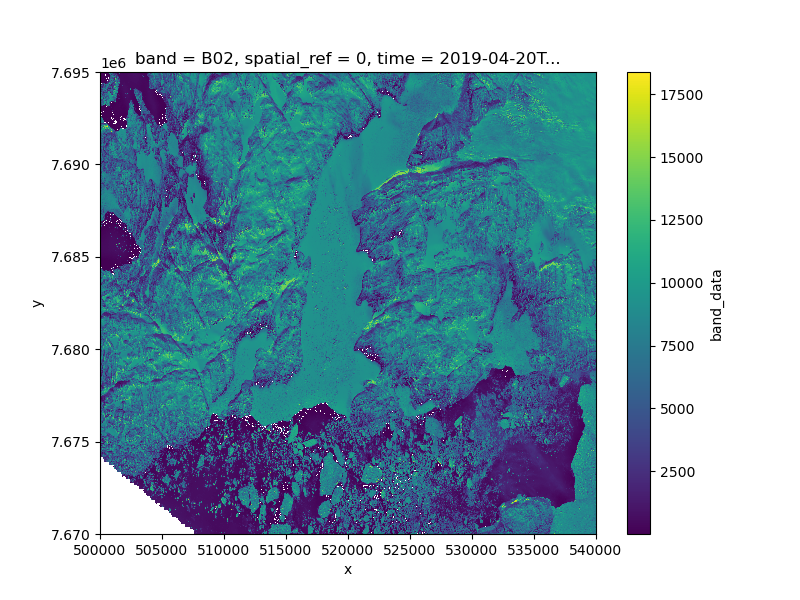

In [34]:
# Plot only the blue band
fig, ax = plt.subplots(figsize=(8,6))
image.sel(band='B02').plot()

## 4. Summary

Congratulations! You've completed the tutorial. In this tutorial you have gained the skills to: 
* Search for optimized cloud data
* Open data into `xarray` arrays, and 
* Manipulate, visualize, and explore the data 

#### Credits
* notebook by: Tasha Snow